# view the result from model output
- do survey for voc and cityscapes dataset

In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)
sys.path.insert(0,project_dir)
print(sys.path)
from torchseg.utils.configs.semanticseg_config import load_config,get_net
from torchseg.utils.disc_tools import get_newest_file,get_checkpoint_from_txt
from torchseg.utils.benchmark import get_loader
# from utils.torch_tools import get_loader
import glob
import torch
import matplotlib.pyplot as plt
from torchseg.utils.survey import dataset_survey
from torchseg.utils.metrics import runningScore,get_scores
from PIL import Image
from tqdm import tqdm
import json
import numpy as np
import cv2

['/home/yzbx/git/torchseg', '/home/yzbx/git/torchseg', '/home/yzbx/git/torchseg', '/home/yzbx/git/torchseg', '/home/yzbx/git/torchseg/notebooks', '/home/yzbx/git/torchseg/notebooks', '/home/yzbx/miniconda3/envs/new/lib/python38.zip', '/home/yzbx/miniconda3/envs/new/lib/python3.8', '/home/yzbx/miniconda3/envs/new/lib/python3.8/lib-dynload', '', '/home/yzbx/.local/lib/python3.8/site-packages', '/home/yzbx/miniconda3/envs/new/lib/python3.8/site-packages', '/home/yzbx/miniconda3/envs/new/lib/python3.8/site-packages/IPython/extensions', '/home/yzbx/.ipython']


In [3]:
#checkpoint_path=os.path.expanduser('~/tmp/logs/pytorch/pspnet/voc2012/voc_benchmark/2018-10-26___17-00-45/model-last-49.pkl')
#config_txt_path='/data02/jiaxin15/tmp/logs/pytorch/PSPUNet/cityscapes/ss059_scale2/2019-11-11___17-03-46/config.txt'
config_txt_path='/home/yzbx/tmp/logs/pytorch/PSPUNet/cityscapes_category/mox001/2020-12-24___15-17-36/config.txt'
checkpoint_path=get_checkpoint_from_txt(config_txt_path)
config=load_config(config_txt_path)
print(json.dumps(config,indent=4))

{
    "_foreground_class_ids": [
        7,
        8,
        11,
        12,
        13,
        17,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        31,
        32,
        33
    ],
    "accumulate": 1,
    "additional_upsample": false,
    "attention_type": "n",
    "augmentation": true,
    "augmentations_blur": true,
    "aux_base_weight": 1.0,
    "auxnet_layer": 4,
    "auxnet_type": "bilinear",
    "backbone_freeze": false,
    "backbone_name": "resnet50",
    "backbone_pretrained": true,
    "batch_size": 4,
    "center_loss": null,
    "center_loss_weight": 1.0,
    "changed_lr_mult": 1.0,
    "checkpoint_path": null,
    "cityscapes_split": "train",
    "class_names": [
        "void",
        "flat",
        "human",
        "vehicle",
        "construction",
        "object",
        "nature",
        "sky"
    ],
    "class_number": 7,
    "class_weight_alpha": 0.0,
    "crop_ratio": [
      

In [11]:
os.environ['TORCH_MODEL_ZOO']='/home/yzbx/.torch/models'
config.txt_path='/home/yzbx/git/torchseg/torchseg/dataset/txt'
net = get_net(config)
train_loader=get_loader(config,'train')
test_loader=get_loader(config,'test')

Found 2975 image files, 2975 annotation files
Found 1525 image files


In [12]:
checkpoint_path=None
if checkpoint_path is None:
    log_dir = os.path.join(config.log_dir, config.net_name,
                       config.dataset_name, config.note)
    ckpt_files=glob.glob(os.path.join(log_dir,'**','model-best-*.pkl'),recursive=True)

    # use best model first, then use the last model, because the last model will be the newest one if exist.
    if len(ckpt_files)==0:
        ckpt_files=glob.glob(os.path.join(log_dir,'**','*.pkl'),recursive=True)

    assert len(ckpt_files)>0,'no weight file found under %s, \n please specify checkpoint path'%log_dir
    checkpoint_path=get_newest_file(ckpt_files)
    print('no checkpoint file given, auto find %s'%checkpoint_path)
else:
    assert os.path.exists(checkpoint_path),'checkpoint path %s not exist'%checkpoint_path

no checkpoint file given, auto find /home/yzbx/tmp/logs/pytorch/PSPUNet/cityscapes_category/mox001/2020-12-24___15-17-36/model-best-4.pkl


In [14]:
# support for cpu/gpu
ngpus=torch.cuda.device_count()
print('use {} gpu'.format(ngpus))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=net
model.to(device)

state_dict=torch.load(checkpoint_path,map_location=device)
# if 'model_state' in state_dict.keys():
#     model.load_state_dict(state_dict['model_state'])
# else:
#     model.load_state_dict(state_dict)
    
model_dict=model.state_dict()
# for key,value in model_dict.items():
#     model_dict[key]=state_dict['module.'+key]
    
model.load_state_dict(model_dict)

model.eval()

use 1 gpu


PSPUNet(
  (backbone): motion_backbone(
    (prefix_net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
     

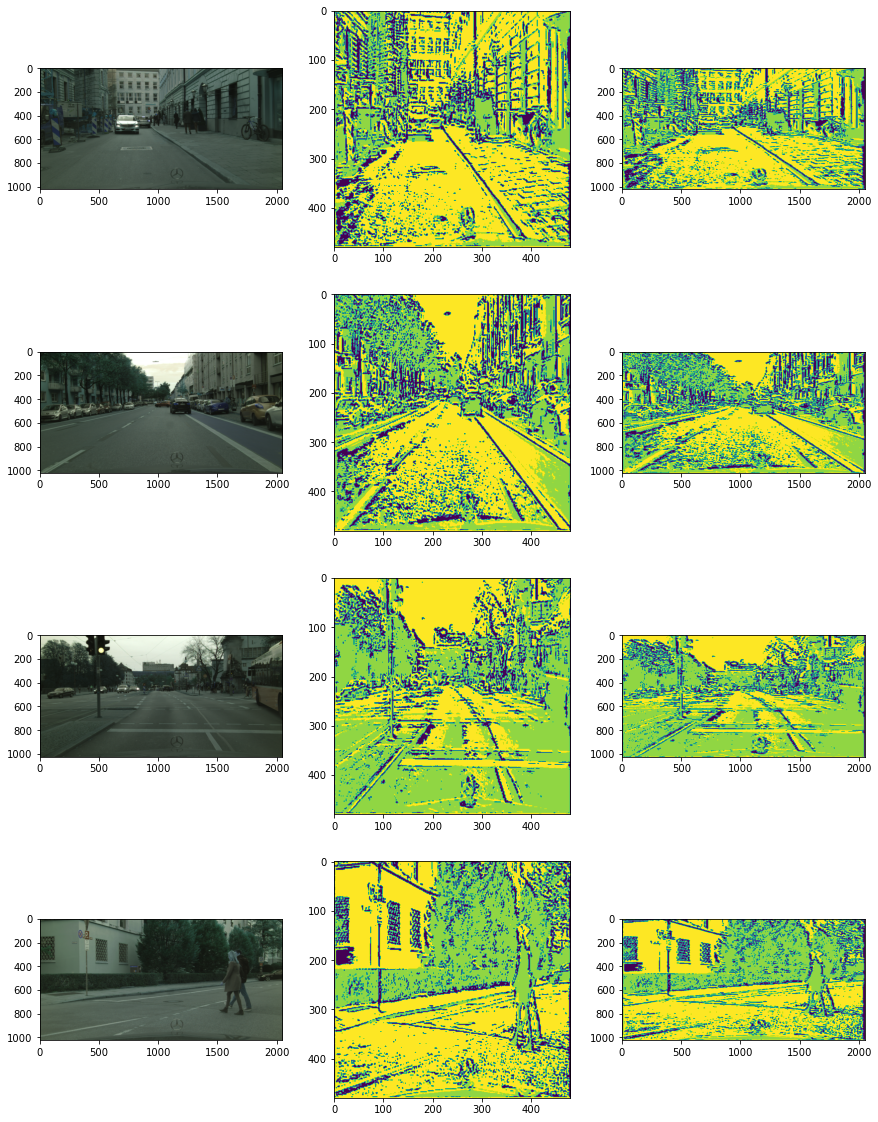

In [15]:
for step, data in enumerate(test_loader):
    # tensor with shape [b,c,h,w]
    images=data['image'].to(device).float()
    image_names=data['filename']

    # tensor with shape [b,c,h,w]
    tensor_outputs=model.forward(images)
    # numpy array with shape [b,h,w]
    outputs = torch.argmax(tensor_outputs,dim=1)

    if isinstance(outputs, dict):
        main_output=outputs['seg']
    elif isinstance(outputs, (list, tuple)):
        main_output=outputs[0]
    elif isinstance(outputs, torch.Tensor):
        main_output=outputs
    else:
        assert False, 'unexcepted outputs type %s' % type(outputs)

    main_output=main_output.data.cpu().numpy()
    
    row=4
    col=4
    fig=plt.figure(figsize=(20,20))
    for idx,f in enumerate(image_names):
        #save_filename=os.path.join(predict_save_path,os.path.basename(f)).replace('.jpg','.png')
        origin_img=cv2.imread(f)
        origin_shape=origin_img.shape
        fig.add_subplot(row,col,idx*row+1)
        plt.imshow(origin_img)
        fig.add_subplot(row,col,idx*row+2)
        plt.imshow(main_output[idx])
        resize_img=cv2.resize(main_output[idx],
                              dsize=(origin_shape[1],origin_shape[0]),
                              interpolation=cv2.INTER_NEAREST)
        fig.add_subplot(row,col,idx*row+3)
        plt.imshow(resize_img)
    
    break


In [14]:
print(len(image_names))

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


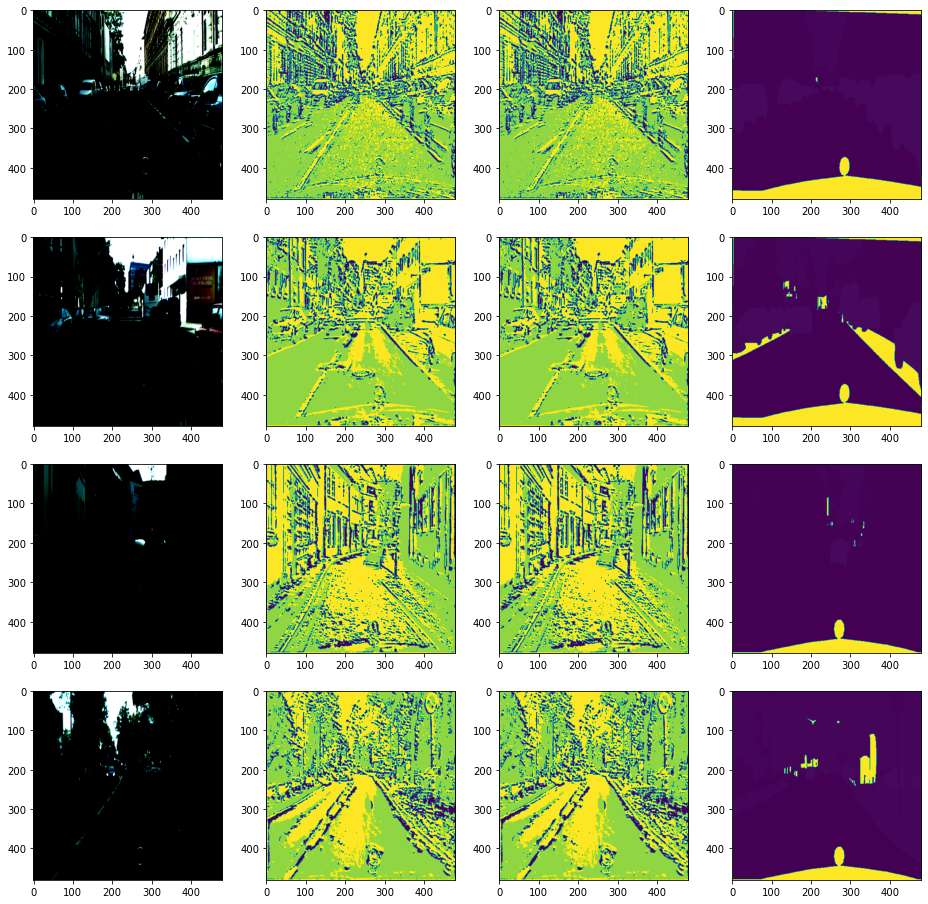

In [16]:
for step, (datas) in enumerate(train_loader):
    # tensor with shape [b,c,h,w]
    images=datas[0]
    labels = datas[1]
    images = torch.autograd.Variable(images.to(device).float())
    labels = torch.autograd.Variable(labels.to(device).long())

    # tensor with shape [b,c,h,w]
    tensor_outputs=model.forward(images)
    # numpy array with shape [b,h,w]
    outputs = torch.argmax(tensor_outputs,dim=1)

    if isinstance(outputs, dict):
        main_output=outputs['seg']
    elif isinstance(outputs, (list, tuple)):
        main_output=outputs[0]
    elif isinstance(outputs, torch.Tensor):
        main_output=outputs
    else:
        assert False, 'unexcepted outputs type %s' % type(outputs)

    main_output=main_output.data.cpu().numpy()
    
    labels_np=labels.data.cpu().numpy()
    images_np=images.data.cpu().numpy()
    b,h,w=labels_np.shape
    fig=plt.figure(figsize=(16,16))
    for idx in range(b):
        #save_filename=os.path.join(predict_save_path,os.path.basename(f)).replace('.jpg','.png')
        origin_img=np.transpose(images_np[idx],(1,2,0))
        origin_shape=origin_img.shape
        fig.add_subplot(4,4,idx*4+1)
        plt.imshow(origin_img)
        fig.add_subplot(4,4,idx*4+2)
        plt.imshow(main_output[idx])
        resize_img=cv2.resize(main_output[idx],
                              dsize=(origin_shape[1],origin_shape[0]),
                              interpolation=cv2.INTER_NEAREST)
        fig.add_subplot(4,4,idx*4+3)
        plt.imshow(resize_img)
        
        fig.add_subplot(4,4,idx*4+4)
        plt.imshow(labels_np[idx])
    
    break


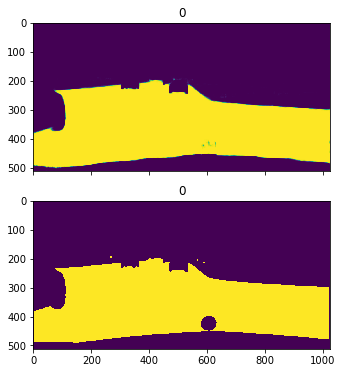

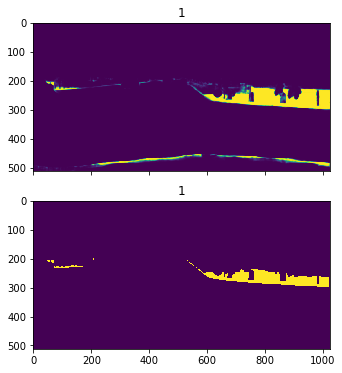

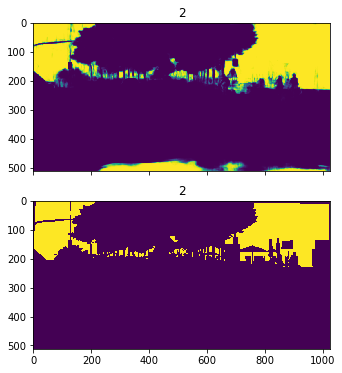

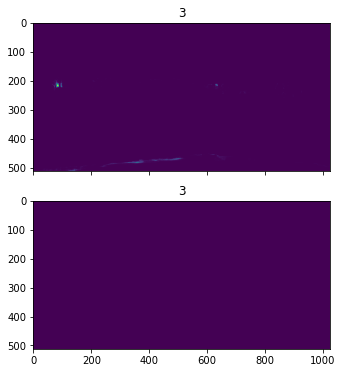

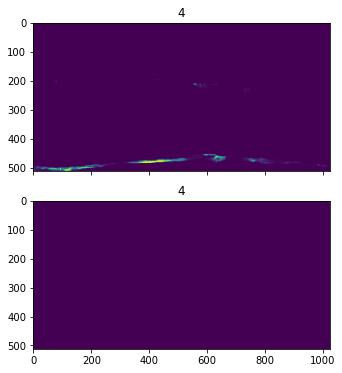

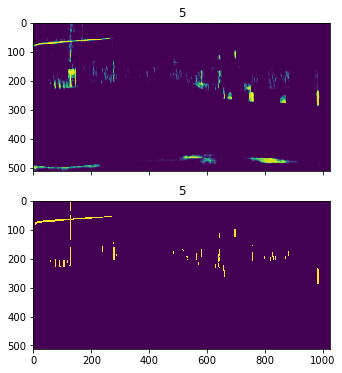

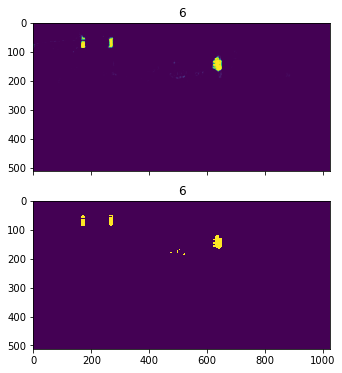

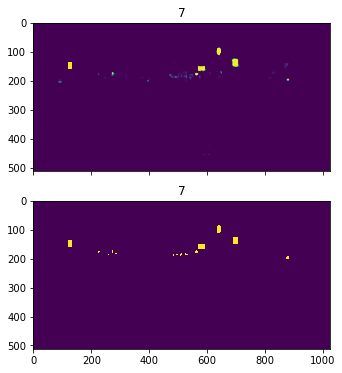

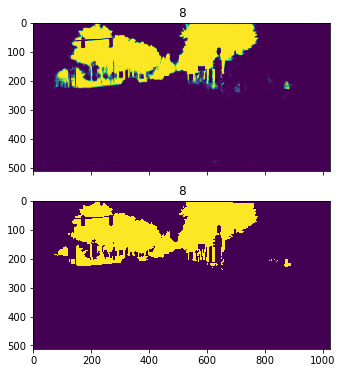

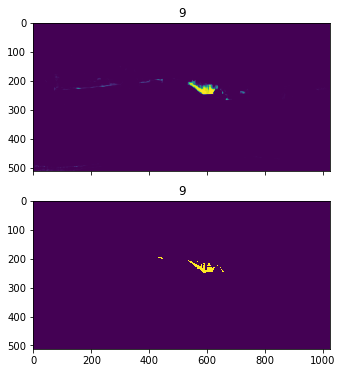

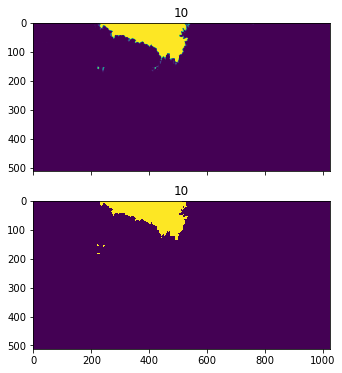

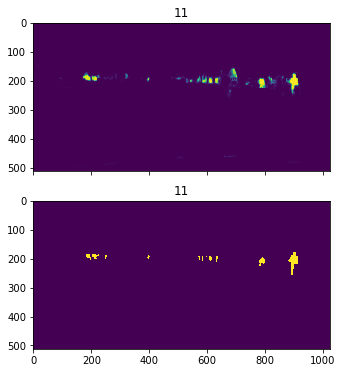

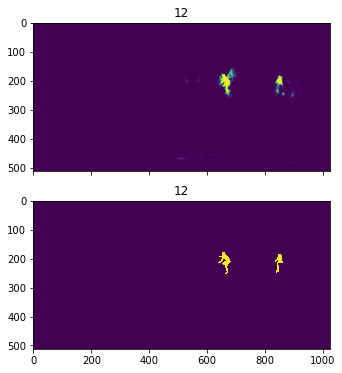

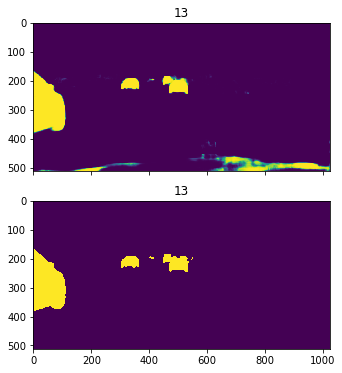

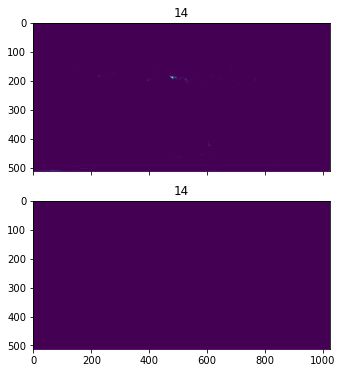

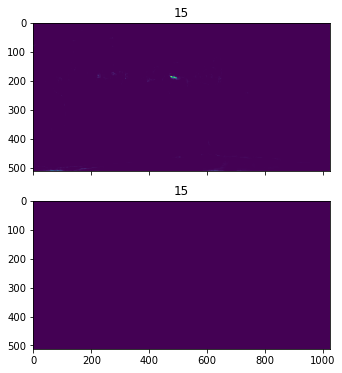

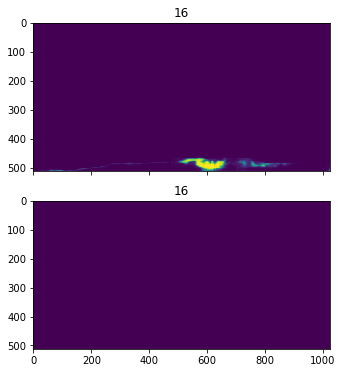

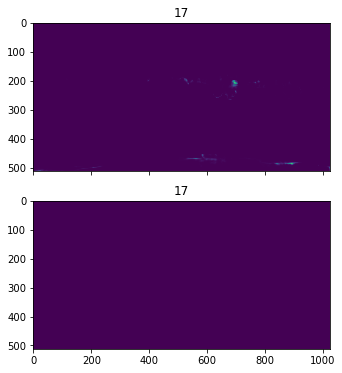

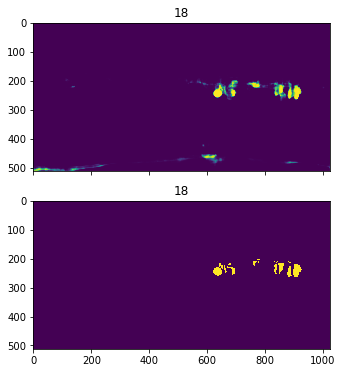

In [25]:
from utils.disc_tools import show_images
batch_images=torch.softmax(tensor_outputs,dim=1).data.cpu().numpy().transpose((0,2,3,1))
batch_labels=labels.data.cpu().numpy()
b,h,w,c=batch_images.shape
images_list=np.split(batch_images,b)
labels_list=np.split(batch_labels,b)
for class_images,label in zip(images_list,labels_list):
    images=np.split(class_images,c,axis=3)
    images=[np.squeeze(img) for img in images]
    gts=[np.squeeze(label==idx) for idx in range(19)]
#     show_images(images)
    for idx,(img,gt) in enumerate(zip(images,gts)):
        show_images([img,gt],[str(idx),str(idx)])

In [8]:
labels=['background','aeroplane','bicycle','bird','boat',
       'bottle','bus','car','cat','chair',
       'cow','diningtable','dog','horse','motorbike',
       'person','pottedplant','sheep','sofa','train','tvmonitor']
for idx in range(b):
    print(np.unique(labels_np[idx]))
    for id in np.unique(labels_np[idx]):
        if id<21:
            print(labels[id])
    print(np.unique(main_output[idx]))
    for id in np.unique(main_output[idx]):
        print(labels[id])

[  0  10  15 255]
background
cow
person
[ 0 10 13 15]
background
cow
horse
person
[  0  19 255]
background
train
[ 0 19]
background
train
[  0  16 255]
background
pottedplant
[ 0 11 15 16]
background
diningtable
person
pottedplant
[  0  15 255]
background
person
[ 0 15]
background
person


In [9]:
config.dataset.with_path=True
train_loader=get_loader(config,'train')

ds=dataset_survey(21)
for step,data in enumerate(train_loader):
    label_files=data['filename'][1]
    for label_file in label_files:
        ds.update_survey(label_file)
ds.summary()

use rotate augmentations**************************************************
Found 1464 image files, 1464 annotation files
{(375, 500): 598, (273, 500): 0, (332, 500): 39, (333, 500): 199, (328, 500): 2, (326, 500): 3, (367, 480): 0, (486, 500): 0, (413, 500): 2, (314, 500): 1, (334, 500): 36, (405, 500): 1, (321, 500): 2, (401, 500): 0, (500, 375): 114, (488, 500): 1, (225, 300): 0, (460, 500): 0, (302, 500): 1, (320, 480): 0, (500, 333): 38, (329, 500): 1, (500, 408): 0, (393, 500): 0, (500, 371): 0, (414, 500): 1, (500, 332): 7, (268, 500): 0, (371, 500): 4, (274, 500): 1, (500, 493): 0, (500, 334): 10, (376, 500): 7, (500, 438): 0, (500, 379): 1, (202, 500): 0, (426, 320): 0, (400, 500): 14, (335, 500): 14, (392, 500): 0, (303, 500): 0, (483, 500): 0, (269, 500): 0, (311, 500): 2, (374, 500): 10, (500, 365): 0, (218, 500): 0, (309, 500): 4, (354, 500): 0, (278, 500): 0, (500, 500): 6, (500, 351): 1, (338, 500): 7, (500, 460): 0, (500, 420): 0, (297, 500): 1, (263, 350): 0, (288, 352)

In [20]:
for key,value in ds.size_survey.items():
    if value > 100:
        print(key,value)

labels=['background','aeroplane','bicycle','bird','boat',
       'bottle','bus','car','cat','chair',
       'cow','diningtable','dog','horse','motorbike',
       'person','pottedplant','sheep','sofa','train','tvmonitor']
ds.class_survey=[182014429, 1780580, 758311, 2232247, 1514260, 1517186, 4375622, 3494749, 6752515, 2861091, 2060925, 3381632, 4344951, 2283739, 2888641, 11995853, 1670340, 2254463, 3612229, 3984238, 2349235]
total_count=np.sum(ds.class_survey)
for name,count in zip(labels,ds.class_survey):
    print(name,1.0*count/total_count)

(1024, 2048) 2971
21
background 0.7335528011120875
aeroplane 0.0071760763900985056
bicycle 0.0030561376986442553
bird 0.0089963803892935
boat 0.006102756087606602
bottle 0.006114548424663869
bus 0.017634589698972022
car 0.014084503806748567
cat 0.0272139210062373
chair 0.01153074142977194
cow 0.00830592011269573
diningtable 0.013628620761325854
dog 0.017510979729770577
horse 0.009203902952435257
motorbike 0.011641773174791661
person 0.048345571382578896
pottedplant 0.00673178820240435
sheep 0.00908591509881648
sofa 0.014557970572807251
train 0.01605723766656555
tvmonitor 0.009467864301684318


In [2]:
from dataset.labels_cityscapes import labels,id2label
argv='--backbone_pretrained=True --backbone_name=vgg16 --upsample_type=bilinear --midnet_scale=15 --batch_size=4 --dataset_name=Cityscapes --note=voc_benchmark --save_model=True --iou_save_threshold=0.5 --n_epoch=50 --test=benchmark'
parser=get_parser()
args=parser.parse_args(argv.split(' '))
config=get_config(args)

config.dataset.with_path=True
train_loader=get_loader(config,'train')

ds=dataset_survey(34)
for step,data in enumerate(tqdm(train_loader)):
    label_files=data['filename'][1]
    for label_file in label_files:
        ds.update_survey(label_file)
ds.summary()

  0%|          | 0/743 [00:00<?, ?it/s]

use rotate augmentations**************************************************
Found 2975 image files, 2975 annotation files


100%|██████████| 743/743 [04:13<00:00,  2.93it/s]

{(1024, 2048): 2972}
[704926, 285758124, 81359604, 94016248, 83611076, 17787538, 75629375, 2034112089, 335879390, 39065130, 11239214, 1258828207, 36199498, 48454166, 547202, 17860177, 3362825, 67748425, 499872, 11458040, 30429862, 879410593, 63937223, 221821128, 67098908, 7425255, 385891560, 14772328, 12990290, 2493375, 1300575, 12863955, 5445145, 22734421]


In [21]:
names=[]
for label in labels:
    if not label.ignoreInEval:
        print(label.name,label.id,label.trainId)
        names.append(label.name)
print(','.join(names))

total_count=np.sum(ds.class_survey)
for idx,count in enumerate(ds.class_survey):
    label=id2label[idx]
    if not label.ignoreInEval:
        print(label.name,1.0*count/total_count)

road 7 0
sidewalk 8 1
building 11 2
wall 12 3
fence 13 4
pole 17 5
traffic light 19 6
traffic sign 20 7
vegetation 21 8
terrain 22 9
sky 23 10
person 24 11
rider 25 12
car 26 13
truck 27 14
bus 28 15
train 31 16
motorcycle 32 17
bicycle 33 18
road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,vegetation,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
road 0.014084503806748567
sidewalk 0.0272139210062373
building 0.013628620761325854
wall 0.017510979729770577
fence 0.009203902952435257
pole 0.00908591509881648
traffic light 0.01605723766656555
traffic sign 0.009467864301684318


In [26]:
argv='--backbone_pretrained=True --backbone_name=vgg16 --upsample_type=bilinear --midnet_scale=15 --batch_size=4 --dataset_name=VOC2012 --note=voc_benchmark --save_model=True --iou_save_threshold=0.5 --n_epoch=50 --test=benchmark'
args=parser.parse_args(argv.split(' '))
config=get_config(args)

config.dataset.with_path=True
val_loader=get_loader(config,'val')
origin_run_score=runningScore(21)
resize_run_score=runningScore(21)
labels=['background','aeroplane','bicycle','bird','boat',
       'bottle','bus','car','cat','chair',
       'cow','diningtable','dog','horse','motorbike',
       'person','pottedplant','sheep','sofa','train','tvmonitor']
for step,data in enumerate(val_loader):
    label_files=data['filename'][1]
    input_images=data['image'][0]
    label_images=data['image'][1]
    label_images=label_images.data.cpu().numpy()
    #net_inputs= torch.autograd.Variable(input_images.to(device).float())
    net_inputs=inputs_images.to(device).float()
    
    # numpy array with shape [b,c,h,w]
    outputs=net(net_inputs)
    if isinstance(outputs, dict):
        main_output=outputs['seg']
    elif isinstance(outputs, (list, tuple)):
        main_output=outputs[0]
    elif isinstance(outputs, torch.Tensor):
        main_output=outputs
    else:
        assert False, 'unexcepted outputs type %s' % type(outputs)
    
    # numpy array with shape [b,h,w]
    main_output = torch.argmax(main_output,dim=1)
    main_output = main_output.data.cpu().numpy()
    
    for idx,f in enumerate(label_files):
        origin_label_pil=Image.open(f)
        origin_label_image=np.array(origin_label_pil,dtype=np.uint8)
        origin_size=origin_label_image.shape
        origin_output_image=cv2.resize(main_output[idx],dsize=(origin_size[1],origin_size[0]),interpolation=cv2.INTER_NEAREST)
        
        # miou for origin_label
        origin_run_score.update(label_trues=origin_label_image,label_preds=origin_output_image)
        # miou for resize_label
        resize_run_score.update(label_trues=label_images[idx],label_preds=main_output[idx])

use rotate augmentations**************************************************
Found 1449 image files, 1449 annotation files


/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [27]:
for run_score in [origin_run_score,resize_run_score]:
    score, class_iou = run_score.get_scores()
    for k, v in score.items():
        print(k, v)
    for key,value in class_iou.items():
        print(labels[key],value)

Overall Acc: 	 0.7883916612152035
Mean Acc : 	 0.35179125706177483
FreqW Acc : 	 0.671013073016401
Mean IoU : 	 0.24522689499980416
background 0.8141622642088696
aeroplane 0.41811788352894774
bicycle 0.06124541262651667
bird 0.09570190651990934
boat 0.1651923255992842
bottle 0.06771591032632741
bus 0.2071139797790084
car 0.4126555802481028
cat 0.3798254936643623
chair 0.0012570405723718867
cow 0.22415631033928987
diningtable 0.1321476066638616
dog 0.136540606264237
horse 0.1552178755441006
motorbike 0.4051920967258573
person 0.491805564744537
pottedplant 0.14403124020068986
sheep 0.29049328538376423
sofa 0.1030953758889693
train 0.3299878479067561
tvmonitor 0.1141091882601241
Overall Acc: 	 0.7890290714461385
Mean Acc : 	 0.3525042970431157
FreqW Acc : 	 0.6718681169851904
Mean IoU : 	 0.24608062687117502
background 0.8148819221163184
aeroplane 0.4191570627402818
bicycle 0.060505372182196614
bird 0.09048757879899928
boat 0.1664262185579114
bottle 0.06434055546247675
bus 0.2068920815733

In [35]:
from utils.benchmark import save_pil_image,voc_color_map
cmap=voc_color_map()
palette=list(cmap.reshape(-1))
save_file='/tmp/pil.png'
save_pil_image(origin_output_image.astype(np.uint8),save_file,palette)
print(origin_label_image.shape)
print(origin_output_image.shape)
print(label_images.shape)
print(main_output.shape)
print(origin_output_image.dtype)

(500, 500)
(500, 500)
(1, 720, 720)
(1, 720, 720)
int32


In [36]:
pil_image=Image.open(save_file)
read_image=np.array(pil_image,dtype=np.uint8)
print(np.count_nonzero(read_image!=origin_output_image))
print(np.unique(read_image))
print(np.unique(origin_output_image))

0
[ 0  5  6 10 11 15 19]
[ 0  5  6 10 11 15 19]


In [43]:
print(images.shape)

torch.Size([2, 3, 640, 640])


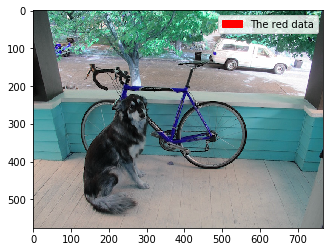

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2
import os
red_patch = mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch])

img=cv2.imread(os.path.expanduser('~/Pictures/dog.jpg'))
plt.imshow(img)
plt.show()